<a href="https://colab.research.google.com/github/MatheusOrange211/Sirio_Libanes_ICU_Prediction/blob/main/Visualizando_os_dados_Sirio_Libanes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploração dos dados - Buscando entender um pouco mais o que temos

<img src="https://github.com/MatheusOrange211/Sirio_Libanes_ICU_Prediction/raw/main/image/image_banner.jpg">

Para entendermos melhor como nosso conjunto de dados é e qual modelo ir implementando, primeiro devemos entender o que temos de dados. Afinal, saber quais dados são faltantes, quais informações podemos ter que realmente ajudarão, dentre outras coisas, serão de caráter fundamental para o modelo obter uma boa performance. Abaixo, realizaremos uma exploração dos nossos dados, com foco em compreender melhor o arcabouço de informações que podemos extrair.

Primeiramente importo as bibliotecas que serão usadas nesta parte do projeto. Elas contêm ferramentas necessárias para a exploração dos dados.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import missingno as msno
import time

tempo_inicial = time.time()
sns.set()

# 1.DADOS

O time de data science nos disponibilizou o seguinte conjunto de dados.

In [ ]:
dados = pd.read_excel("https://github.com/MatheusOrange211/Sirio_Libanes_ICU_Prediction/raw/main/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx")

Sobre os dados, temos que:<br>
* Foram limpos e ajustados para uma escala de -1 até 1.

* Dados disponíveis:
  * Informações demográficas do paciente (03)
  * Doenças anteriores agrupadas de pacientes (09)
  * Resultados de sangue (36)
  * Sinais vitais (06)

* No total, são 54 recursos, expandidos quando pertinentes à média, mediana, máximo, mínimo, dif e dif.

\begin{equation}
diff = max - min
\end{equation}

\begin{equation}
diff \space relativo = \frac{diff}{mediana}
\end{equation}

**Dados ausentes**<br>
Um dos maiores desafios de trabalhar com dados de saúde é que a taxa de amostragem varia entre os diferentes tipos de medições. Por exemplo, os sinais vitais são coletados com mais frequência (geralmente de hora em hora) do que os laboratórios de sangue (geralmente diariamente).

**Dica:**<br>
É razoável supor que um paciente que não tem uma medição registrada em uma janela de tempo esteja clinicamente estável, podendo apresentar sinais vitais e exames de sangue semelhantes às janelas vizinhas. Portanto, pode-se preencher os valores ausentes usando a entrada seguinte ou anterior. Atenção aos problemas de multicolinearidade e variância zero nesses dados ao escolher seu algoritmo. 

> **multicolinearidade**: refere-se a preditoras correlacionadas com outras preditoras. A multicolinearidade ocorre quando o modelo inclui vários fatores correlacionados não apenas à sua variável de resposta, mas também uns aos outros. Em outras palavras, resulta quando você tem fatores que são, de certa forma, um pouco redundantes. A multicolinearidade aumenta os erros padrão dos coeficientes. O aumento dos erros padrão, por sua vez, significa que os coeficientes para algumas variáveis independentes podem não ser significativamente diferentes de 0. Em outras palavras, ao super-inflacionar os erros padrão, a multicolinearidade torna algumas variáveis estatisticamente insignificantes quando deveriam ser significativas. Sem multicolinearidade (e, portanto, com erros padrão mais baixos), esses coeficientes poderiam ser significativos. **Uma maneira de medir a multicolinearidade é o fator de inflação da variância (VIF)**. Se nenhum fator estiver correlacionado, os VIFs serão todos **1**. Para resolver isso ou Removemos do modelo as preditoras que são altamente correlacionadas ou usamos Regressão de Mínimos Quadrados Parciais (PLS) ou Análise de Componentes Principais. ([Explicação mais aprofundada](https://blog.minitab.com/pt/basta-lidando-com-a-multicolinearidade-na-analise-de-regressao#:~:text=A%20multicolinearidade%20ocorre%20quando%20o,certa%20forma%2C%20um%20pouco%20redundantes.) )


# 2.FUNÇÕES 

Essa função retorna um resumo simples do que temos no nosso conjunto de dados. Informações como quantidade de linhas e colunas e quantidade totais de valores Not a Number (Nan), que causam muitos problemas na hora de maninpular dados, são apresentados.

In [ ]:
def resume_dataframe(dataset  : pd.DataFrame):
  
  data_nan = dataset.isnull().any().any() #retorno os dados Not a Number das colunas
  dataset_types = list (set(dataset.dtypes.values)) #com o set realizo um "filtro" removendo dados repetidos
  print("################ RESUMO BÁSICO ####################\n")
  #shape nos retorna uma tupla com dois valores, sendo um referente a linhas e o outro a coluna, respectivamente.
  print(f"Quantidade de instâncias: {dataset.shape[0]} (linhas)\nQuantidade de Atributos: {dataset.shape[1]} (colunas)\n")

  if data_nan:
    print(f"Possui dados NaN ? {data_nan}\nQuantidade de NaN totais: {dataset.isnull().sum().values.sum()}\n")
  else:
    print("Não há dados ausentes neste dataset\n")

  print(f"Tipos de  dados que temos :\n{dataset_types}\n")
  print("##################################################\n")

Esta função é responsável por mostrar quais colunas possuem dados ausentes em um dataset. Primeiramente, realiza-se uma verificação se é Nulo e com o auxílio do método any, aplica-se tal ação nas colunas do dataframe. Os valores são transformados para o formato de dicionário, onde temos:

```
{"coluna_1" : True, .....}
```
Por meio de um laço for, percorremos todo este dicionário gerado e com uma estrutura de condição IF, verificamos se o valor corresponde a True. Caso seja, armazena-se o nome da coluna em uma lista que é retornada posteriormente ao final da checagem em todas as colunas do DataFrame.


In [ ]:
def colunas_ausentes(dataset: pd.DataFrame):
  faltantes = dict(dataset.isnull().any())
  col_faltantes = []

  for  i in faltantes.items():
    if i[1] == True:
      col_faltantes.append(i[0])
    else:
      pass
  
  return col_faltantes

Essa função é responsável por gerar uma tabela detalhada e formatada sobre determinada coluna. As informações que ela gera ajudam a compreeender mais sobre o comportamento de terminada coluna e sua distribuição a longo da tabela.


Função responsável por plotar um gráfico de barra simples, onde deve-se passar os dados a serem plotados,  o título do gráfico, os títulos para os rótulos de eixo Y e eixo X, assim como um valor limite para `ylim `, responsável por gerar os valores na parte lateral do gráfico. Por último, passar, uma lista para as legendas, tornando mais fácil o entendimento do gráfico por parte do analista de dados.

In [ ]:
def plot_graficos_barra_simples(data : pd.DataFrame,title : str,ylabel_title:str,xlabel_title:str,
                                ylim_values:int,list_legend: list):
    figura4 =  data.plot(kind='bar',figsize=(15,5),colormap='Dark2')
    figura4.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}%"))
    plt.title(title,size=18)
    plt.ylabel(ylabel_title)
    plt.xlabel(xlabel_title)
    plt.xticks(rotation=0)
    plt.ylim(0,ylim_values)
    plt.legend(list_legend)
    for p in figura4.patches:
      figura4.annotate(format(p.get_height(), '.0f')+ "%",
                      (p.get_x() + p.get_width() / 2, p.get_height()),
                      ha = 'center', va = 'center', 
                      size=15,
                      xytext = (0,9),
                      textcoords = 'offset points')
      
    plt.show()

In [ ]:
def preencher_colunas(dados):

  continuas_colunas_features = dados.iloc[:,13:-2].columns
  features_continuas = dados.groupby(['PATIENT_VISIT_IDENTIFIER'],as_index=False)[continuas_colunas_features].fillna(method='bfill').fillna(method='ffill')
  categoricas_features = dados.iloc[:, :13]
  saida = dados.iloc[:,-2:]
  dados_finais = pd.concat([categoricas_features, features_continuas, saida],ignore_index=True,axis=1)
  dados_finais.columns = dados.columns
  
  return dados_finais

Essa função é responsável por realizar um filtro do qual busca-se manter valores referentes a janela de até 2 duas horas. Aplicando-se esta função em um groupby, ocorrerá que os dados serão agrupados. Uma vez agrupados, faremos, por meio desta função, uma verificação onde se qualquer uma das linhas conferidas for igual a 1, ou seja, se em um agrupamento do paciente **x** em todos os períodos, se, por exemplo, na janela `0-4`, tivermos o valor de `ICU` == 1  (ou seja, um valor True), será aplicado nessa linha, da primeira janela de admissão (no caso, 0-2), o valor igual a 1 para a coluna ICU. Visualizando:


| WINDOW  |ICU   |   
|---------|------|
| 0-2        | 0  | 
|     2-4    |  0 | 
|       4-6  |   1| 
|       6-12  |   0| 

Veja como na janela de 4-6 horas, o paciente já foi para UTI. o que esta função fará é por o valor 1 logo na primeira Janela:

| WINDOW  |ICU   |   
|---------|------|
| 0-2        | 1  | 
|     2-4    |  0 | 
|       4-6  |   0| 
|       6-12  |   0|

E assim, retornaremos apenas a primeira linha.


In [ ]:
def  prepare_window(rows):
  if(np.any(rows['ICU'])):
    rows.loc[rows['WINDOW']== '0-2','ICU'] = 1
  return  rows.loc[rows['WINDOW'] == '0-2']

In [ ]:
def formated_table(dataset : pd.DataFrame, dicionario : dict  = None, title_index :str = None):
  frequency = dataset.value_counts() #contabiliza os valores passados 
  percentage = (dataset.value_counts(normalize=True) * 100).round(3)  #normaliza-se e se converte num modo de porcentagem
  final_dataset = pd.DataFrame({"Frequencia":frequency,"Porcentagem":percentage}) #cria-se um novo dataframe

  if dicionario: #caso um dicionário seja passado, modifica-se o nome das colunas, pois o valor da variável será True
    final_dataset.rename(index = dicionario, inplace = True)
  
  if title_index: #o mesmo vale nesse caso. Substitui-se os valores do index
    final_dataset.rename_axis(title_index,axis=1,inplace=True)
  
  return final_dataset

A função abaixo será responsável por cruzar duas colunas de dados. Dela podemos averiguar questões como:
Quantos porcento das pessoas que forma admitidas em um intervalo de até 2 horas necessitaram de UTI? ou até mesmo, das pessoas que foram internadas, quantos porcento foram admitidas num intervalo de mais de 12 horas.

In [ ]:
def crosstab_data(dataset1: pd.DataFrame, dataset2:pd.DataFrame,normal:str = "index",dicio1:dict= None, dicio2: dict = None):
    #realiza-se o cruzamento entre duas colunas do mesmo conjunto de dados
    # e arrendoda-se os valores existentes em duas casas decimais, sendo a normalização por padrão por index
    dataframe = (pd.crosstab(dataset1,dataset2,normalize=f"{normal}")*100).round(2) 
    
    if dicio1: #caso exista um dicionario para as colunas, modifica-se
      dataframe.rename(index=dicio1,inplace=True)

    if dicio2: #modifica-se os valores do index caso um dicionario seja passado
      dataframe = dataframe.rename(columns=dicio2)
    
    return dataframe

Essa função realiza a ação de realizar uma query em determinada `janela` passada em um  determinado `dataset`, do qual filtramos e buscamos todos os valores que não estão presentes na variável 

In [ ]:
def periodos_admissao_porcentagens(dataset,janela):
  dataset_usado = dataset
  paciente_janela_hora = dataset_usado.query(f"WINDOW == '{janela}' and ICU == 1")['PATIENT_VISIT_IDENTIFIER']
  dataset_usado = dataset_usado.query("PATIENT_VISIT_IDENTIFIER not in @paciente_janela_hora")
  periodo_horas = dataset_usado.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window)
  pacientes_uti_freq_porcentagem = formated_table(periodo_horas['ICU'])

  return pacientes_uti_freq_porcentagem

Nessa função, o que acontece é que passando nosso dataframe (contendo NaN e strings - não se preocupe quanto a isso), filtramos as colunas e ficamos apenas com as que são numéricas. Depois passamos o método de correlação e damos um .`pipe()` (com ele, a gente pode aplicar funções no DataFrame, por exemplo). Aplicamos um lambda e passamos um `np.tril()`. O que ele fará é retornar os valores maiores que -1 numa matrix de diagonal `k-therizada` (Leia a [documentação](https://numpy.org/doc/stable/reference/generated/numpy.tril.html) para um maior aprofundamento). Criamos as colunas e index e empilhamos as colunas que são geradas durante a correlação. Passando outro `pipe()`, retornamos apenas os valores que são maiores que o parâmetro que passamos na declaração da função. Por último damos um `query()` para realizar um filtro em valores que estão na coluna `level_0` e não em `level_1` .

In [ ]:
def correlated_columns_harrison(dataset, threshold = 0.95):
  df = dataset[dataset.describe().columns]  #fica-se apenas com as colunas que possuem valores numéricos
  return (
      df.corr().pipe(lambda df1: pd.DataFrame(np.tril(df1,k=-1),  
                                              columns = df.columns,
                                              index = df.columns,
                                              )
      ) 
      .stack()
      .rename("pearson")
      .pipe(
          lambda s: s[s.abs() >threshold].reset_index()
      )
      .query("level_0 not in level_1")
  )

Nessa função, iremos criar uma lista com as colunas com valores correlacionados que serão descartadas. Para as duas colunas que ela possui, iremos dropar valores repetidos e adicionar os que sobram a uma lista que é retornada.

In [ ]:
def descartar_colunas_correlacionadas(dataset: pd.DataFrame):
    colunas_com_muita_correlacao = [] #cria-se uma lista vazia 
    for valor in dataset['level_0'].drop_duplicates().values: #dropa-se o nome duplicados de colunsa presentes na coluna level_0
      colunas_com_muita_correlacao.append(valor) #adiciona-se os valores na lista
    for valor in dataset['level_1'].drop_duplicates().values:#dropa-se o nome duplicados de colunsa presentes na coluna level_1
      colunas_com_muita_correlacao.append(valor)  #adiciona-se os valores na lista
    return colunas_com_muita_correlacao

# 3.PARTINDO PARA A ANÁLISE

Pra começar, vamos ver o que temos logo de cara no dataset. Compreender sua composição é de fundamental importância para uma boa tomada de decisão.

In [ ]:
dados.head(3)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.59322,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0,-0.162393,-0.5,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.59322,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0,-0.025641,-0.5,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0


Acima, imprimimos apenas as 3 primeiras linhas do DataFrame. A quantidade de colunas é grande e podemos analisar isso ou pouco melhor abaixo

In [ ]:
resume_dataframe(dados)

################ RESUMO BÁSICO ####################

Quantidade de instâncias: 1925 (linhas)
Quantidade de Atributos: 231 (colunas)

Possui dados NaN ? True
Quantidade de NaN totais: 223863

Tipos de  dados que temos :
[dtype('O'), dtype('int64'), dtype('float64')]

##################################################



Temos **1925** linhas e **231** colunas no total. Nosso dataframe `dados` (nome que darei para o conjunto de dados original), possui valores NaN em um total de **22363** células. Isso significa que precisaremos tratar estes dados e buscar tratar estes valores ausentes para quando treinado, não termos problemas de desempenho no modelo. Por fim, temos uma lista de informções que nos indicam que temos  dados do tipo **Inteiro** (*int64*), tipo **Object** (*o*) e tipo **Real** ou **Float**, em inglês (*float64*).
Para fins de conhecimento temos que para tipo **Object**:
>O Object tipo de dados pode apontar para dados de qualquer tipo de dados, incluindo qualquer instância de objeto que seu aplicativo reconhece. ([Link para Leitura](https://docs.microsoft.com/pt-br/dotnet/visual-basic/language-reference/data-types/object-data-type#:~:text=O%20Object%20tipo%20de%20dados,objeto%20que%20seu%20aplicativo%20reconhece.))

## 2.1- Compreendendo um pouco mais sobre Not a Number - NaN

**Not a Number** ou apenas **NaN** é definido como:
>  Um valor ou símbolo usado nas linguagens de programação para representar um valor numérico indefinido ou irrepresentável. Seu uso sistemático foi introduzido pelo padrão IEEE 754 em 1985, junto com a representação de outras quantidade não finitas tais como infinitos ([link para leitura](https://pt.wikipedia.org/wiki/NaN))

Na análise de dados, NaN devem ser tratados com muita atenção. Dados Ausentes, conforme lista Matt Harrison, autor de *Machine Learning - Guia de Referência Rápida*, podem ser lidados da seguinte forma:
* Removendo qualquer linha que contenha dados ausentes;
* Removendo qualquer coluna que contenha dados ausentes;
* Imputar dados aos valores ausentes;
* Criar uma coluna  para informar que os dados estavam ausentes.

Contudo, em cada caso, devemos avaliar bem a forma como iremos tratar esse tipo de dados, precisando conhecer melhor o porquê dele possuir valores vazios. Apenas descartar, por exemplo, todas as linhas com dados ausentes, pode reduzir drasticamente nosso dataframe além de jogar informações importantes fora, e isso pode impactar negativamente o desempenho do nosso modelo.<br>
Vamos então explorar estes dados NaN, e ver qual a sua porcentagem em relação as colunas.

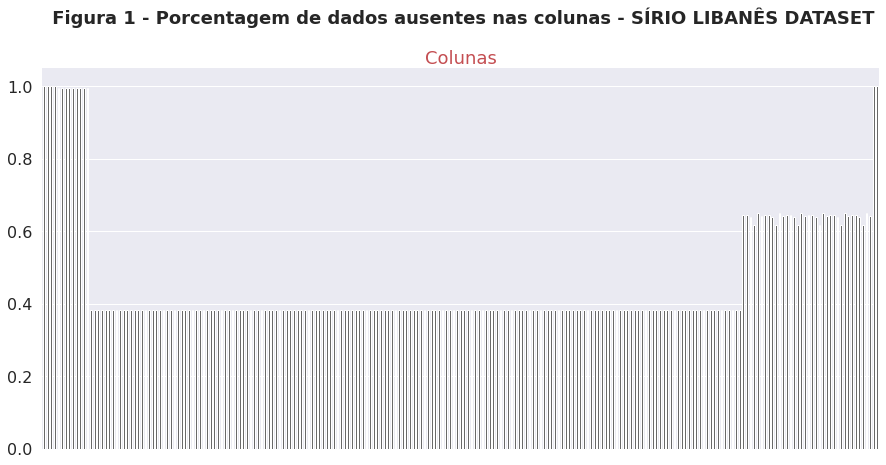

In [ ]:
grafico_dados_faltantes = msno.bar(dados.sample(500),figsize=(15,7))
plt.title(" Figura 1 - Porcentagem de dados ausentes nas colunas - SÍRIO LIBANÊS DATASET",
          size=18,weight='bold')
plt.xlabel("\nColunas",color='r',size=18)

grafico_dados_faltantes.get_figure();

Com a ajuda da biblioteca Missingno, podemos analisar nosso conjunto de dados de forma global e ver como todas as colunas se comportam em relação a quantidade de dados ausentes. Abaixo temos uma visão geral que mostra que grande parte das colunas apresentam apenas 40% de dados, sendo o resto em sua maioria, valores NaN. Parece que na verdade, temos um padrão estabelecido em grande parte das colunas. Isso já será explicado.

Tendo essas informações já temos uma boa noção de que simplesmente descartar linhas e/ou colunas com dados faltantes não será uma boa ideia. Analisaremos mais afundo estes dados e entenderemos melhor o que há aqui.

In [ ]:
print(f"Quantidade de Colunas com dados faltantes: {dados.isna().any().sum()}")

Quantidade de Colunas com dados faltantes: 225


Vejamos abaixo, algumas colunas relacionadas a valores de exames clínicos e de sinais vitais. Apresentaremos abaixo um heatmap que auxilia na visualizando de dados relacionados e seus faltantes. O motivo? simples. Se analisarmos essas colunas que possuem informações importantes e que em sua maioria são as que possuem dados faltando, podemos compreender algum padrão formado.

### 2.1.1 -Uma breve visualização de dados faltantes

Por conta da grande quantidade de colunas, fica muito difícil de analisar visualmente como cada coluna se comporta . Nesse caso, opta-se por pegar 12 colunas referentes as médias de:

* ALBUMINA - responsável principalmente por manter constante os níveis de líquido nos vasos sanguíneos;
* CÁLCIO - responsável pela formação e desenvolvimento dos ossos e dentes;
* GLICOSE - função primordial é de fornecer energia aos organismos vivos;
* HEMOGLOBINA - responsável pela coloração vermelha do sangue;
* LEUCÓCITOS -  têm como função a defesa contra organismos estranhos;
* POTÁSSIO - é necessário para o funcionamento normal das células, nervos e músculos;
* FREQUÊNCIA CARDIACA - a velocidade do ciclo cardíaco medida pelo número de contrações do coração por minuto;
* FREQUÊNCIA RESPIRATÓRIA -  é a designação dada em fisiologia animal e em medicina ao número de ciclos respiratórios que um animal completa num lapso específico de tempo;
* TEMPERATURA;
* SATURAÇÃO DE OXIGÊNIO - saturação de oxigênio do sangue, ou seja a porcentagem de oxigênio que está sendo transportada na circulação sanguínea;
* ITU - no caso, ICU.

In [ ]:
dados_sanguineos_respiracao = dados[['ALBUMIN_MEAN','CALCIUM_MEAN','CALCIUM_MEAN','GLUCOSE_MEAN','HEMOGLOBIN_MEAN',
      'LEUKOCYTES_MEAN','POTASSIUM_MEAN','HEART_RATE_MEAN','RESPIRATORY_RATE_MEAN',
      'TEMPERATURE_MEAN','OXYGEN_SATURATION_MEAN','ICU']]

Quantidade de valores NaN nas colunas

In [ ]:
dados_sanguineos_respiracao.isna().sum()

ALBUMIN_MEAN              1104
CALCIUM_MEAN              1104
CALCIUM_MEAN              1104
GLUCOSE_MEAN              1104
HEMOGLOBIN_MEAN           1104
LEUKOCYTES_MEAN           1104
POTASSIUM_MEAN            1104
HEART_RATE_MEAN            685
RESPIRATORY_RATE_MEAN      748
TEMPERATURE_MEAN           694
OXYGEN_SATURATION_MEAN     686
ICU                          0
dtype: int64

Usaremos um Correlograma, uma variante de um Mapa de Calor (Heat Map), para analisarmos se há correlações entre as colunas selecionadas.

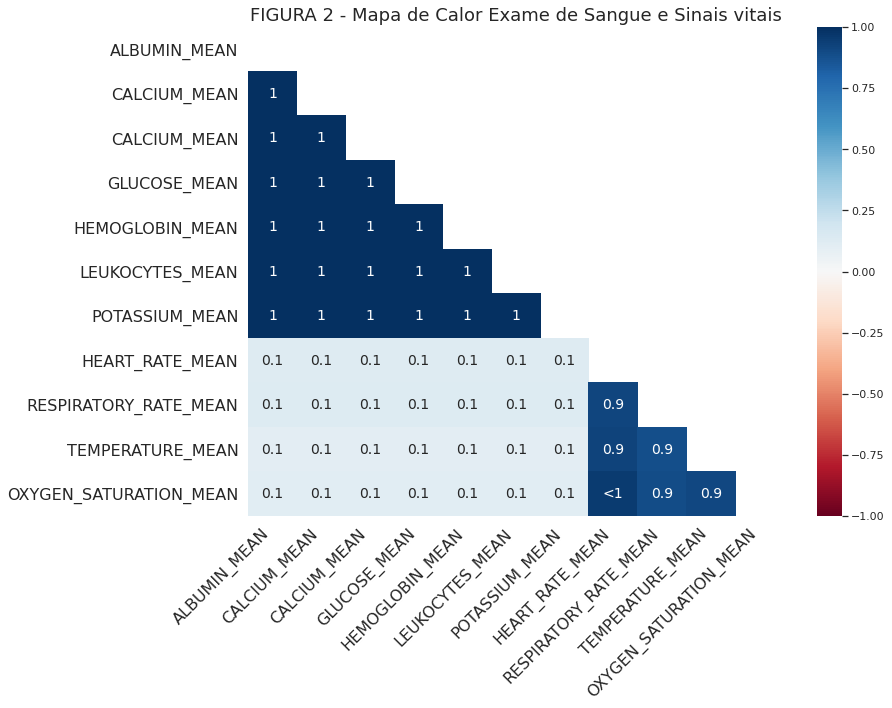

In [ ]:
grafico_sang_resp = msno.heatmap(dados_sanguineos_respiracao,figsize=(12,9))
plt.title("FIGURA 2 - Mapa de Calor Exame de Sangue e Sinais vitais",size=18)
grafico_sang_resp.get_figure();

Acima temos que há correlação entre atributos que apresentam dados ausentes. Para os valores, temos a seguinte significação:

* Um valor próximo a  -1 (menos um) significa que se uma variável aparecer, é muito provável que a outra variável esteja ausente.
* Um valor próximo a 0 (zero) significa que não há dependência entre a ocorrência de valores ausentes de duas variáveis.
* Um valor próximo a 1 (um) significa que se uma variável aparecer, é muito provável que a outra variável esteja presente. 

No nosso caso, analisando essas colunas, conclui-se para a maioria das colunas possuem uma correlação positiva. Nos casos próximos a zero, temos que os valores  presentes ou ausentes não têm qualquer efeito uns sobre os outros.

Vamos utilizar um dendograma para entender melhor os agrupamentos (clusters) existentes nesse conjunto de dados que foi realizado. Por definição, um dendograma é:
>Diagrama de árvore que exibe os grupos formados por agrupamento de observações em cada passo e em seus níveis de similaridade. O nível de similaridade é medido ao longo do eixo vertical (alternativamente, você pode exibir o nível de distância) e as diferentes observações são listadas ao longo do eixo horizontal.(Referência: [Minitab](https://support.minitab.com/pt-br/minitab/18/help-and-how-to/modeling-statistics/multivariate/how-to/cluster-observations/interpret-the-results/all-statistics-and-graphs/dendrogram/))

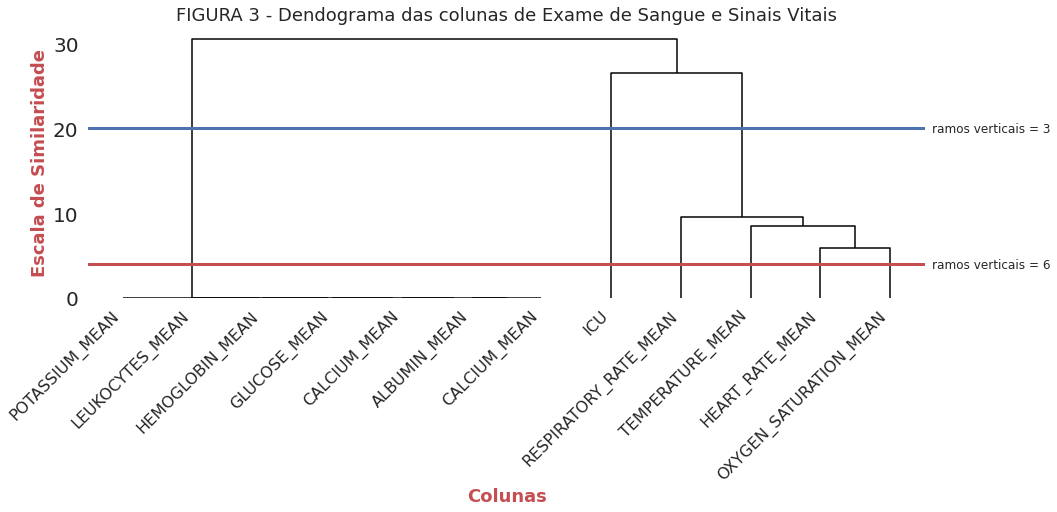

In [ ]:
grafico_dendograma_sang_resp = msno.dendrogram(dados_sanguineos_respiracao,figsize=(15,5),orientation='top')
plt.ylabel("Escala de Similaridade",size=18,color='r',weight='bold')
plt.xlabel("Colunas",size=18,color='r',weight='bold')

plt.axhline(y=4,color='r',linewidth=3)
plt.text(138, 4, 'ramos verticais = 6', fontsize=12, va='center', ha='right', backgroundcolor='w')

plt.axhline(y=20,color='b',linewidth=3)
plt.text(138, 20, 'ramos verticais = 3', fontsize=12, va='center', ha='right', backgroundcolor='w')

plt.title("FIGURA 3 - Dendograma das colunas de Exame de Sangue e Sinais Vitais",size=18)
grafico_dendograma_sang_resp.get_figure();


A partir do gráfico podemos entender melhor quais colunas possuem uma similaridade mais próxima uma da outra. `HEART_RATE_MEAN` e `OXYGEN_SATURATION_MEAN` possuem bastante similaridade. Outro ponto interessante são os ramos verticais indicados no gráfico. Na linha de azul, temos 3 classes identificadas que vão se ramificando até gerarem no final, 6 classes. A classe da linha azul de número 3 (da esquerda para direita) é a responsável por agrupar informações de sinais vitais:
* `RESPIRATORY_RATE_MEAN`;
* `TEMPERATURE_MEAN`;
* `HEART_RATE_MEAN`;
* `OXYGEN_SATURATION_MEAN`.

Enquanto que na classe 1 da linha azul (da esquerda da direita), temos informaçõe referentes aos exames de sangue dos pacientes, por isso a similaridade deles estarem todas em um mesmo nível. O eixo y representa o limiar em alguma distância de linkagem. Por último, veja que `ICU`(coluna referente a UTI) possui sim um agrupamento em comum com os dados de sinais vitais em certo ponto, afinal, é apartir dos sinais vitais, da forma como eles estão, que podemos definir a necessidade de UTI, por exemplo (claro, é um dos fatores decisivos).

### 2.1.2 -O que realmente são os nossos dados NaN?

Já visualizamos um pouco a relação existente entre algumas colunas, mas ainda não entendemos de fato o que nossos dados são e como estão organizados. Isso será demonstrado agora.

Primeiramente, se você analisar a coluna  `PATIENT_VISIT_IDENTIFIER`, verá que nosso dataset possui muitos valores repetidos, como pode ver abaixo:

In [ ]:
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

Na realidade, cada valor deste representa um identificador de paciente visitante. As informações que são apresentadas decorrem do período de tempo em que este está internado. Isso explica o porquê de haver colunas com valores NaN em alguns momentos e em outros não. Resumindo, não temos em cada linha um paciente, e sim um conjunto **x** de pacientes em um intervalo de tempo para cada, onde houveram medições de suas respectivas capacidades respiratórias e os resultados dos exames de sangue ao longo do tempo em que estiveram internados. Sendo assim, não podemos simplesmente analisar cada linha de maneira geral, temos que prestar atenção nessa peculiaridade que é fundamental importância para a continuidade deste projeto.

Abaixo, temos quais colunas possuem valores NaN. Observe que as colunas que possuem dados faltantes são justamente as relacionadas a exames sanguíneos e medições de sinais vitais.

In [ ]:
colunas_ausentes(dados)

['DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER',
 'ALBUMIN_MEDIAN',
 'ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'ALBUMIN_DIFF',
 'BE_ARTERIAL_MEDIAN',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_ARTERIAL_DIFF',
 'BE_VENOUS_MEDIAN',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BE_VENOUS_DIFF',
 'BIC_ARTERIAL_MEDIAN',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_ARTERIAL_DIFF',
 'BIC_VENOUS_MEDIAN',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BIC_VENOUS_DIFF',
 'BILLIRUBIN_MEDIAN',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BILLIRUBIN_DIFF',
 'BLAST_MEDIAN',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'BLAST_DIFF',
 'CALCIUM_MEDIAN',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CALCIUM_DIFF',
 'CREATININ_MEDIAN',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATIN

São essas, as coluna que estão com dados faltantes e que precisarão ser tratadas. Para fazer isso é simples, partindo do fato de que o que temos em nosso conjunto de dados são valores para um paciente (até mesmo o identificador de visita do paciente), devemos entender que a falta de valores em alguns casos se dá por:
* O paciente, em uma Janela de até 2 horas, não possuiu tempo para realizar todos os exames, logo algumas colunas naturalmente iniciam vazias;
* Nem todos os exames são realizados de só vez;
* Os exames demoram um período de tempo para ficarem prontos, assim como as medições que em certos intervalos demoram ou não foram medidos;
* Os valores de medições de sinais vitais não são tipos de dados que mudam brutalmente em curto espaço de tempo (óbvio, com algumas exceções), assim como muito resultados só estão prontos depois que o paciente já deu entrada na UTI do hospital.

Com essas observações, compreende-se que grande parte dos nosso dados NaN possuem um porquê de não estarem preenchidos, e para arrumar isso, passo os método `fillna` para realizar a manipulação destes dados ausentes. Passo em um primeiro momento, o método de preenchimento 'bfill' para preencher os valores anteriores a uma valor NaN, casos existam, e depois um método ' ffill' para valores posteriores a NaN. O motivo? como já explicado, a situação de um paciente, no geral, não se altera de forma discrepante, e mesmo que isso venha a ocorrer, estes dois métodos de preenchimentos auxiliarão na correção disso. Crio então, uma nova variável que conterá agora os dados limpos e veremos se ainda há valores NaN no DataFrame.




Primeiramente, separo as colunas que possuem dados referente a exames e onde se encontram os valores ausentes, exlcuindo deste *slice* (fatiamento), apenas as primeiras colunas categoricas (como `AGE_PERCENTIL` e outras que não possuem influência em medições clínicas, assim como as colunas `WINDOW`e `ICO`).

In [ ]:
dados_limpos = dados.copy() #copiando o dataframe original

In [ ]:
colunas_features = dados_limpos.iloc[:,13:-2].columns #realizando um slice das colunas com dados de exames e dela extraindo apenas o nome das colunas

#Agrupando pela coluna de identificação da visita do paciente e aplicando fillna e seus dois métodos, nas colunas de dados clínicos selecionados anteriormente
dados_limpos.iloc[:,13:-2] = dados_limpos.groupby(['PATIENT_VISIT_IDENTIFIER'],as_index=False)[colunas_features].fillna(method='bfill').fillna(method='ffill')

dados_limpos.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.33913,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27272

Vejamos se ainda possuímos valores ausentes neste dataset.

In [ ]:
resume_dataframe(dados_limpos)

################ RESUMO BÁSICO ####################

Quantidade de instâncias: 1925 (linhas)
Quantidade de Atributos: 231 (colunas)

Possui dados NaN ? True
Quantidade de NaN totais: 45

Tipos de  dados que temos :
[dtype('O'), dtype('int64'), dtype('float64')]

##################################################



dropa-se tais valores ausentes restantes.

In [ ]:
dados_limpos = dados_limpos.dropna()
resume_dataframe(dados_limpos)

################ RESUMO BÁSICO ####################

Quantidade de instâncias: 1920 (linhas)
Quantidade de Atributos: 231 (colunas)

Não há dados ausentes neste dataset

Tipos de  dados que temos :
[dtype('O'), dtype('int64'), dtype('float64')]

##################################################



verificando agora, temos que 5 linhas foram removidas, e não há mais nenhum valor ausente no DataFrame.

## 2.2 - Como as janelas de admissão estão distribuídas?

Temos as janelas (windows) de admissão que foram agrupadas para facilitar o tempo de admissão de pacientes no hospital.

|WINDOW|DESCRIÇÃO|
|:---------:|:-----------------------------------:|
| 0-2	    |  From 0 to 2 hours of the admission |
| 2-4	    | From 2 to 4 hours of the admission  |
| 4-6	    |  From 4 to 6 hours of the admission |
| 6-12    |	From 6 to 12 hours of the admission |
| Above-12|     	Above 12 hours from admission |


**OBSERVAÇÃO FEITA PELA EQUIPE DE PESQUISA**: **Cuidado para NÃO usar os dados quando a variável de destino estiver presente, pois a ordem do evento é desconhecida (talvez o evento de destino tenha acontecido antes de os resultados serem obtidos). Eles foram mantidos lá para que possamos aumentar este conjunto de dados em outros resultados posteriormente.**

Antes de escolhermos com qual janela de Pacientes trabalharemos, vejamos algumas informações importantes de todas as janelas de dados. A começar pela frequência de valores para cada uma das janelas.

In [ ]:
intervalo_admissao = {"0-2": "Até 2h","2-4":"De 2h até 4h","4-6": "De 4h até 6h",	
                      "6-12": "De 6h até 12h","ABOVE_12":"Acima de 12h"}
                      
formated_table(dados_limpos['WINDOW'],dicionario=intervalo_admissao)

,Frequencia,Porcentagem
De 6h até 12h,384,20.0
Até 2h,384,20.0
De 2h até 4h,384,20.0
Acima de 12h,384,20.0
De 4h até 6h,384,20.0


A partir da limpeza dos dados, na remoção de dados ausentes, chagamos um divisão perfeita de frequências nas janelas de admissão.<br>
Todavia, veja como estão separadas as janelas de admissão em relação a ao paciente ter ido ou não para UTI dentro aquela faixa de tempo.

In [ ]:
dicio_uti = {0:"nao_foi_para_uti",1:"foi_para_uti"}
janela_por_uti = crosstab_data(dados_limpos['WINDOW'],dados_limpos['ICU'],
                               normal='index',
                               dicio1=intervalo_admissao,
                               dicio2= dicio_uti)

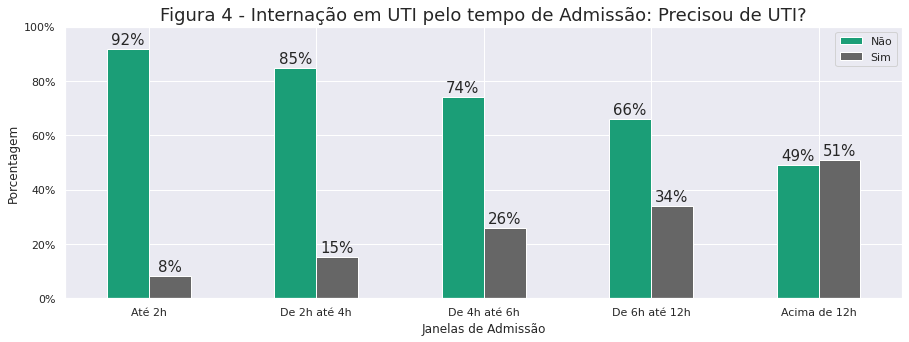

In [ ]:

plot_graficos_barra_simples(janela_por_uti,"Figura 4 - Internação em UTI pelo tempo de Admissão: Precisou de UTI?",
                            "Porcentagem","Janelas de Admissão",100,['Não','Sim'])


Conforme os horários avançam, maior vai se tornando a quantidade pessoas que precisaram de UTI, até que o valor ultrapassa os que não precisam, conforme é mostrado na janela acima de 12 horas.

## 2.3 - Removendo Pacientes que já estão na UTI e Trabalhando com janela de pacientes de até 2 horas.

Uma coisa importante a saber é que não utilizaremos dados de pacientes que já estão na UTI. Isso acarreta inúmeros problemas para um modelo de Machine Learning que tentará justamente prever se a pessoa dará entrada ou não a uma UTI. Contudo, pode ocorrer da pessoa já entrar no hospital e logo no período de Até 2 horas ir direto para a Unidade de Terapia Intensiva. Os dados deste paciente não poderão ser usados em nenhuma outra janela. Este é um outro caso do qual será necessário filtrar informações para assim manter a integridade do modelo de Machine Learning e evitar possíveis *vazamentos de dados*.

Para isso, aplica-se um `.query`que deve procurar pela coluna `WINDOW` os valores categóricos que são iguais a janela de até 2 horas (0-2h) e com situação de UTI igual a um ('ICU == 1'), ou seja, que já estão internados. Dos valores encontrados, deseja-se pegar a coluna  `	PATIENT_VISIT_IDENTIFIER` da qual será armazenada em uma variável que será usada em outra `query()` mas que buscará todos os valores para `	PATIENT_VISIT_IDENTIFIER` diferentes dos que estão na lista que passamos.

In [ ]:
a_remover_ate_duas_horas = (dados_limpos.query("WINDOW == '0-2' and ICU == 1")['PATIENT_VISIT_IDENTIFIER']).values

dados_pacientes_nao_admitidos_duas_hr = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover_ate_duas_horas")
dados_pacientes_nao_admitidos_duas_hr.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.33913,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27272

Removemos agora os pacientes que aprsentavam entrar na UTI logo nas primeiras horas (até 2 horas) do nosso dataframe.

Por fim, fazemos, aplicando a função `prepare_window`(explicada na seção FUNÇÃO), verificamos todos os grupos de pacientes, e naqueles em que são encontrados algum valor de `ICU`igual a 1, coloca-se o valor um na janela de 0-2 horas e exclui-se as demais linhas desse grupo. Isso é aplicado para todos os pacientes. O resultado é esse:

In [ ]:
dados_duas_horas = dados_pacientes_nao_admitidos_duas_hr.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window)
dados_duas_horas.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0

Acima, temos de forma mais destacada o comportamento apresentado por pacientes com janela de admissões mais tardias. A necessidade de internação em UTI vai aumentando.

## 2.4 - Compreendendo um pouco sobre as Colunas listadas

Em nosso conjunto de dados, temos algumas colunas de dados que trazem informações referente a doenças que determinado paciente possui ou não. Conhecer um pouquinho sobre estas doenças ajuda a entender os impactos que podem gerar em pacientes que necessitem de UTI por conta do Coronavírus.<br>
Começando então pela coluna `HTN` que refere-se a **Hipertensão** (*entendida como a pressão arterial acima de 14/9 e é considerada grave quando a pressão está acima de 18/12*). Conforme matéria da Revista [Veja](https://saude.abril.com.br/medicina/por-que-a-hipertensao-aumenta-o-risco-de-complicacoes-do-coronavirus/), a Hipertensão pode agravar o quadro de pacientes que foram infectados pela covid-19. Como aponta a própria matéria:
> Em um dos trabalhos, feito com mais de mil pacientes, dos 173 que foram acometidos de maneira severa pela Covid-19, 23% tinham pressão alta e 16%, diabetes. Em outro, de 140 internados por causa da Covid-19, 30% possuíam hipertensão e 12%, a glicemia cronicamente elevada. [...] 

Ainda segundo a mesma reportagem, temos que:

> Para infectar as células, o Sars-Cov-2 utiliza a enzima conversora de angiotensina 2, chamada de ECA-2, presente nas células de pulmão, rins e outros órgãos. E alguns remédios usados pelos hipertensos elevam o nível dessas enzimas”, explica a cardiologista Ludhmila Abrahão Hajjar, diretora de Ciência, Tecnologia e Inovação da Sociedade Brasileira de Cardiologia (SBC). 

Isso significa que devemos manter uma atenção a esses dados referentes a hipertensão, sendo de grande importância pra um treino de modelo de classificação, talvez. Presumindo então que em nossos dados os valores tenham o seguite significado:

* 0 = Sem Hipertensão
* 1 = Possui Hipertensão

Vejamos como é a relação de pessoas que possuem ou não hipertensão e a necessidade de UTI

In [ ]:
dicio_hipertensao ={0:"nao_possui_hipertensao",1:"possui_hipertensao"}

rel_hipertensao_uti = crosstab_data(dados_duas_horas['HTN'],dados_duas_horas['ICU'],
                                    dicio1 = dicio_hipertensao, dicio2 = dicio_uti)

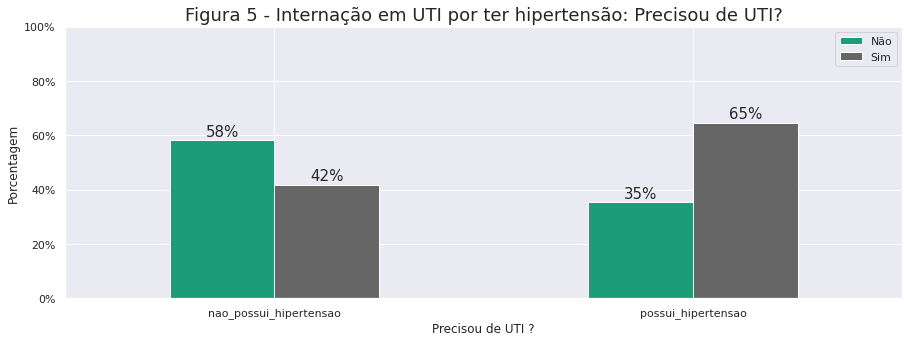

In [ ]:
plot_graficos_barra_simples(rel_hipertensao_uti,"Figura 5 - Internação em UTI por ter hipertensão: Precisou de UTI?",
                            "Porcentagem","Precisou de UTI ?",100,['Não','Sim'])

Das pessoas que não possuem hipertensão,  **42%** necessitaram de internação em um leito de UTI. Por outro lado, dos pacientes que sofrem da doença, cerca de **65%** precisaram ser internados. Essa **Diferença**  indica o impacto que a hipertensão causa, junto da covid-19 em pacientes. Essa coluna pode ser de grande importância para o modelo e análise de resultados.

Nas colunas, temos uma coluna que nos diz quais pacientes são 
**IMUNOCOMPROMETIDOS** (coluna `IMMUNOCOMPROMISED`). Temos por definição que:
>Os pacientes imunocomprometidos são aqueles cujos mecanismos normais de defesa contra infecção estão comprometidos. Esses pacientes podem incluir, entre outros, receptores de transplante e de implante, queimados, portadores do vírus da imunodeficiência humana (HIV) e indivíduos com câncer. Como o sistema imune do paciente torna-se mais e mais comprometido, os organismos menos virulentos progressivamente se tornam mais perigosos, deixando os pacientes com graves defeitos imunológicos mais suscetíveis a um número e uma variedade maior de doenças infecciosas. (Referência: [Medicina Net](https://www.medicinanet.com.br/conteudos/qualidade-e-seguranca/5355/pacientes_imunocomprometidos.htm))

Isso significa que por estarem nesta situação, tornam-se alvos fáceis para o Coronavírus. Em nosso conjunto de dados, temos, assumindo os significados os seguintes valores:
* 0 = Não é Imunocomprometido;
* 1 = É Imunocomprometido;


In [ ]:
dicio_imunocomprometido = {0: "nao_e_imunocomprometido", 1: "e_imunocomprometido"}

imunocomprometido_freq_porcentagem = formated_table(dados_duas_horas['IMMUNOCOMPROMISED'],
                                                    dicionario = dicio_imunocomprometido)
imunocomprometido_freq_porcentagem

,Frequencia,Porcentagem
nao_e_imunocomprometido,295,83.807
e_imunocomprometido,57,16.193


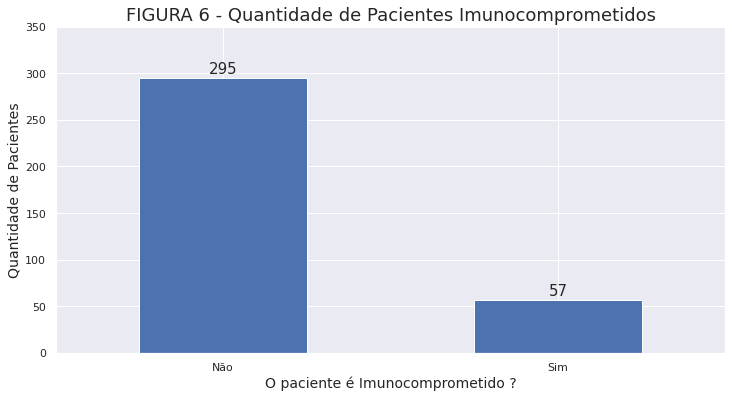

In [ ]:
figura6 = imunocomprometido_freq_porcentagem['Frequencia'].plot(kind='bar',figsize=(12,6))

plt.title("FIGURA 6 - Quantidade de Pacientes Imunocomprometidos",size=18)
plt.ylabel("Quantidade de Pacientes",size=14)
plt.xlabel('O paciente é Imunocomprometido ?',size=14)
plt.xticks([0,1],["Não","Sim"],rotation = 0)
plt.ylim(0,350)
for p in figura6.patches:
     figura6.annotate(format(p.get_height(), '.0f'),
                      (p.get_x() + p.get_width() / 2, p.get_height()),
                      ha = 'center', va = 'center', 
                      size=15,
                      xytext = (0,9),
                      textcoords = 'offset points')
plt.show()


A quantidade de pacientes que não são Imunocomprometidos é maior em nosso conjunto de dados.

Abaixo, você visualiza a relação do paciente ser ou não imunocomprometido e a necessidade UTI.

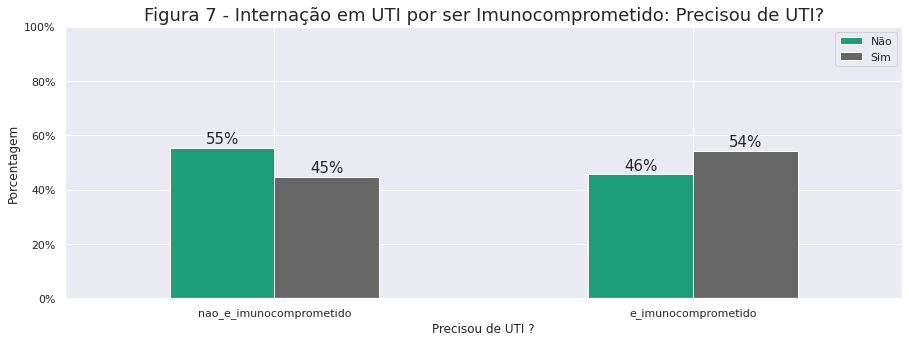

In [ ]:
rel_imunocomprometido_uti= crosstab_data(dados_duas_horas['IMMUNOCOMPROMISED'],
                                    dados_duas_horas['ICU'],
                                    dicio1 = dicio_imunocomprometido, 
                                    dicio2 = dicio_uti)

plot_graficos_barra_simples(rel_imunocomprometido_uti,
                            "Figura 7 - Internação em UTI por ser Imunocomprometido: Precisou de UTI?",
                            "Porcentagem",
                            "Precisou de UTI ?",
                            100,
                            ['Não','Sim'])

Os valores se assemenlham bastante, só que de forma inversa. Ou seja, se de um lado 55% dos não imunocomprometidos não precisaram de UTI, do outro, dos pacientes que são imunocomprometidos,  54% precisaram e foram internados em uma Unidade de Terapia Intensiva.

## 2.5 -Colunas com alta correlação

Iremos tratar a questão de correlações altas entre colunas. O motivo é simples: geralmente colunas com correlações altas geram problemas em modelos de Machine Learning. Acabam interferindo de modo que possamos ter resultados enganosos ou enviesados.

A esse ponto, já procuraremos entender, nos aspecto geral, as correlações existentes para todas as colunas em nosso dataset. Aplicando nossa função `correlated_columns_harrison`, podemos filtrar valores onde a correlação é maior que `0.95` por exemplo.

In [ ]:
dados_correlacao = correlated_columns_harrison(dados_limpos,threshold = 0.95)
dados_correlacao

,level_0,level_1,pearson
3,ALBUMIN_MAX,ALBUMIN_MEDIAN,1.000000
4,ALBUMIN_MAX,ALBUMIN_MEAN,1.000000
5,ALBUMIN_MAX,ALBUMIN_MIN,1.000000
9,BE_ARTERIAL_MAX,BE_ARTERIAL_MEDIAN,1.000000
10,BE_ARTERIAL_MAX,BE_ARTERIAL_MEAN,1.000000
...,...,...,...
272,HEART_RATE_DIFF_REL,HEART_RATE_DIFF,0.985774
273,RESPIRATORY_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF,0.990656
274,TEMPERATURE_DIFF_REL,TEMPERATURE_DIFF,0.999882
275,OXYGEN_SATURATION_DIFF_REL,OXYGEN_SATURATION_MIN,-0.980243


Filtrarei as colunas que se repetem e um novo dataframe é instanciado na variável `colunas_com_muita_correlacao`.

In [ ]:
colunas_com_muita_correlacao = descartar_colunas_correlacionadas(dados_correlacao)

dados_sem_correlacao = dados_duas_horas.drop(columns = colunas_com_muita_correlacao)
dados_sem_correlacao.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_DIFF,BE_ARTERIAL_DIFF,BE_VENOUS_DIFF,BIC_ARTERIAL_DIFF,BIC_VENOUS_DIFF,BILLIRUBIN_DIFF,BLAST_DIFF,CALCIUM_DIFF,CREATININ_DIFF,FFA_DIFF,GGT_DIFF,GLUCOSE_DIFF,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_DIFF,LACTATE_DIFF,LEUKOCYTES_DIFF,LINFOCITOS_DIFF,NEUTROPHILES_DIFF,P02_ARTERIAL_DIFF,P02_VENOUS_DIFF,PC02_ARTERIAL_DIFF,PC02_VENOUS_DIFF,PCR_DIFF,PH_ARTERIAL_DIFF,PH_VENOUS_DIFF,PLATELETS_DIFF,POTASSIUM_DIFF,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_DIFF,SODIUM_DIFF,TGO_DIFF,TGP_DIFF,TTPA_DIFF,UREA_DIFF,DIMER_DIFF,OXYGEN_SATURATION_MEAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.736842,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.935673,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.684211,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.868421,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,0-2,0
5,25,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.815789,0.815789,0.030928,-0.3750,-0.401709,-0.428571,0.252747,-0.247863,-0.567568,-0.626866,-0.575758,-0.333333,0.842105,0-2,0


Agora temos as seguites informações no dataframe:

In [ ]:
resume_dataframe(dados_sem_correlacao)

################ RESUMO BÁSICO ####################

Quantidade de instâncias: 352 (linhas)
Quantidade de Atributos: 64 (colunas)

Não há dados ausentes neste dataset

Tipos de  dados que temos :
[dtype('O'), dtype('int64'), dtype('float64')]

##################################################



Para saber se a exclusão dessas colunas impactarão de maneira positiva a predição dos dados, deveremos testar os modelos de Machine Learning.

Antes de Finalizar, ainda falta uma coisa a se analisar. Temos em nosso Dataframe duas colunas categóricas: `AGE_PERCENTIL` e `WINDOW`. Tanto na variável `dados`(dados originais) quanto em `dados_sem_correlacao`, essas colunas aparecem. Aplicaremos um procedimento chamado **codificação one-shot (one-shot encoding)**. Serão criadas colunas para cada uma das categorias, atribuindo a elas, valores iguais a 0 (zero) e 1 (um). Fazendo isso, podemos manipular algumas coisas.

In [ ]:
dados_get_dummies = pd.get_dummies(dados_sem_correlacao)
dados_get_dummies.head()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_DIFF,BE_ARTERIAL_DIFF,BE_VENOUS_DIFF,BIC_ARTERIAL_DIFF,BIC_VENOUS_DIFF,BILLIRUBIN_DIFF,BLAST_DIFF,CALCIUM_DIFF,CREATININ_DIFF,FFA_DIFF,GGT_DIFF,GLUCOSE_DIFF,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,INR_DIFF,LACTATE_DIFF,LEUKOCYTES_DIFF,LINFOCITOS_DIFF,NEUTROPHILES_DIFF,P02_ARTERIAL_DIFF,P02_VENOUS_DIFF,PC02_ARTERIAL_DIFF,PC02_VENOUS_DIFF,PCR_DIFF,PH_ARTERIAL_DIFF,PH_VENOUS_DIFF,PLATELETS_DIFF,POTASSIUM_DIFF,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_DIFF,SODIUM_DIFF,TGO_DIFF,TGP_DIFF,TTPA_DIFF,UREA_DIFF,DIMER_DIFF,OXYGEN_SATURATION_MEAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,WINDOW_0-2
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.736842,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,1,0,0,0,0,0,1,0,0,0,0,1
2,10,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.935673,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,1,1,0,0,0,0,0,0,0,0,0,1
3,15,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.684211,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,0,0,0,0,1,0,0,0,0,0,0,1
4,20,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.868421,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,0,1,0,0,0,0,0,0,0,0,0,1
5,25,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.815789,0.815789,0.030928,-0.3750,-0.401709,-0.428571,0.252747,-0.247863,-0.567568,-0.626866,-0.575758,-0.333333,0.842105,0,1,0,0,0,0,0,0,0,0,0,1


O uso desta coluna será melhor explicado quando os modelos começarem a serem aplicados, mas desde já, entenda que os deixando assim, podemos facilitar os treinos e nos livramos de coluns catogoricas, pois elas viraram colunas.

In [ ]:
dados_limpos

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.339130,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27

Agora, partiremos para a implementação dos dados e escolha do que tiver o melhor desempenho.

In [ ]:
print("\033[1m" + f"Este Google Colab levou : {(time.time() -  tempo_inicial):.0f} Segundos para executar todo. Muito Obrigado!" + "\033[0m")

Este Google Colab levou : 46 Segundos para executar todo. Muito Obrigado!
